## Introduction

The objective of this project is to use data analysis to determine concrete business objectives for Microsoft as it looks to create a studio to produce original content.

My choice of measurement to determine a film's is ROI, or return on investment, which I define as box office results divided by production budget. This allows for easier interpretation of the figure, such that an ROI equal to one means a film broke even on its budget, and an ROI greater than one means the films intake exceeded its production budget. Another reason I chose ROI is because it can be applied to look at a studio's success over time; as Microsoft creates a new studio, it will need to decide if it wants to continue funding the studio based on initial results.

The premise for my thinking is to look at ROIs for individual studios, then find the studio that Microsoft should look to emulate. Then I will look if traditional markers of success (ratings and popularity) do indeed have a relationship to the studio's success, and if so, what this studio's films have in common.


### Looking at studio and production results

The first step in data exploration will be loading in the necessary packages and data.

In [76]:
# import packages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from zipfile import ZipFile

In [108]:
# read in csv files
movie_gross = pd.read_csv('bom.movie_gross.csv')         # studio and gross info
movies = pd.read_csv('tmdb.movies.csv')                  # ratings and popularity info
movie_budgets = pd.read_csv('tn.movie_budgets.csv')      # budget and gross info

Since my measurement for success will be ROIs, my first step is to combine the budget, box office, and studio info into a workable dataset. To do this, I will merge and clean the movie_gross and movie_budgets data sets.

In [90]:
# clean movie budget data - need budget and gross columns to be workable numbers
for column in ['production_budget','domestic_gross','worldwide_gross']:
    movie_budgets[column] = movie_budgets[column].str.strip('$')
    movie_budgets[column] = movie_budgets[column].map(lambda x : re.sub(',','',x))
    movie_budgets[column] = movie_budgets[column].astype(int)
    
# add columns for domestic and worldwide roi
movie_budgets['domestic_roi'] = movie_budgets['domestic_gross'] / movie_budgets['production_budget']
movie_budgets['worldwide_roi'] = movie_budgets['worldwide_gross'] / movie_budgets['production_budget']

In [92]:
# check that movie_budgets dataframe looks as expected
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,1.789430,6.532577
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,0.587101,2.546673
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,0.122178,0.427892
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1.388403,4.243841
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,1.956408,4.153696


In [166]:
# check for duplicates
movie_budgets.duplicated().value_counts()

False    5782
dtype: int64

Now that ROIs have been calculated for the available films, we will look primarily at domestic ROI data since it is reasonable to conclude that the domestic market will be, at least at first, Microsoft's primary market. 

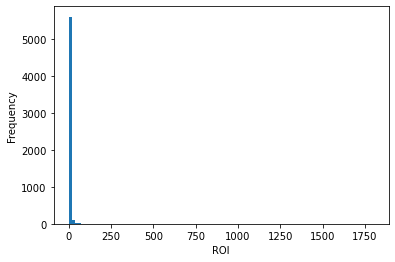

In [99]:
# plot histogram of domestic ROI
fig, ax = plt.subplots()
ax.hist(movie_budgets['worldwide_roi'],bins=100);
ax.set_xlabel('ROI')
ax.set_ylabel('Frequency');

From the initial histogram, it appears that the majority of films have low ROIs (let's say less than 100) while an exceedingly small number of films have a very high ROI. We should examine the outliers and also set parameters on what qualifies as reasonable data.

In [101]:
movie_budgets[movie_budgets['domestic_roi'] > 500]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi
5745,46,"Jun 30, 1972",Deep Throat,25000,45000000,45000000,1800.0,1800.0


There is only one film with a domestic ROI greater than 500, *Deep Throat* from 1972. Since this is a pornographic film, I am comfortable excluding it from the data set both on the basis of genre and being an outlier. Additionally, we should exclude any films where domestic or worldwide gross is zero. While this is perhaps meaningful data, it may also be untrustworthy since the likelihood of a studio releasing a film that not a single person will pay to see is highly unlikely. 

In [103]:
# exclude movies where domestic or worldwide gross is zero
# while this data may in fact be meaningful, it may also qualify as untrustworthy
movie_budgets_posGross = movie_budgets[movie_budgets['domestic_roi'] > 0]

# given that there is only one film with either domestic or worldwide roi > 500, we will exlcude it
movie_budgets_posGross = movie_budgets[movie_budgets['domestic_roi'] < 500]

In [131]:
# check number of movies remaining in dataset
movie_budgets_posGross.shape[0]

5781

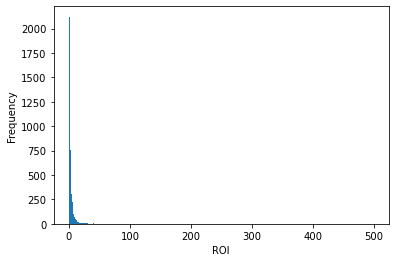

In [104]:
# new distribution of ROIs
fig, ax = plt.subplots()
ax.hist(movie_budgets_posGross['worldwide_roi'],bins=500);
ax.set_xlabel('ROI')
ax.set_ylabel('Frequency');

Though the vast majority of films still appear to have ROIs below 50, the range of ROIs is now much more condensed. Moreover, this distribution makes sense - most films will have average returns and only a handful of films will generate high-multiple returns. 

In [107]:
# look at the films with ROIs greater than 50 - this number is arbitrarily chosen based on the histogram
movie_budgets_posGross[movie_budgets_posGross['worldwide_roi'] > 50]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi
3464,65,"May 25, 1977",Star Wars Ep. IV: A New Hope,11000000,460998007,786598007,41.908910,71.508910
3525,26,"Jun 11, 1982",ET: The Extra-Terrestrial,10500000,435110554,792965326,41.439100,75.520507
4112,13,"Jun 16, 1978",Grease,6000000,181813770,387510179,30.302295,64.585030
4247,48,"Apr 19, 2002",My Big Fat Greek Wedding,5000000,241438208,374890034,48.287642,74.978007
4248,49,"Feb 24, 2017",Get Out,5000000,176040665,255367951,35.208133,51.073590
4249,50,"Jan 20, 2017",Split,5000000,138141585,278964806,27.628317,55.792961
4424,25,"Mar 9, 1994",Four Weddings and a Funeral,4500000,52700832,242895809,11.711296,53.976846
4567,68,"Dec 15, 1939",Gone with the Wind,3900000,198680470,390525192,50.943710,100.134665
4589,90,"Aug 13, 1997",The Full Monty,3500000,45950122,261249383,13.128606,74.642681
4664,65,"Oct 20, 2010",Paranormal Activity 2,3000000,84752907,177512032,28.250969,59.170677


Now that the provided budget and box office data has been cleaned, it can be combined with the provided studio data to look at which studios are successful.

In [112]:
# check for duplicates in movie_gross dataframe
movie_gross.duplicated().value_counts()

False    3387
dtype: int64

In [162]:
# check for missing values in movie_gross dataframe, focusing on domestic_gross (since we are looking at domestic ROI)
movie_gross['domestic_gross'].isna().value_counts()

False    3359
True       28
Name: domestic_gross, dtype: int64

In [117]:
# there are 28 missing values out of 3387 films in the dataset
# for ease and because the domestic gross data cannot be approximated by distribution, we will exclude those
domestic_gross = movie_gross[~movie_gross['domestic_gross'].isna()]
domestic_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [132]:
# check number of movies remaining in this dataset
domestic_gross.shape[0]

3359

In [118]:
# check counts of films by year
domestic_gross['year'].value_counts()

2015    449
2016    433
2011    397
2012    393
2014    391
2013    345
2010    323
2017    320
2018    308
Name: year, dtype: int64

Since we now only have domestic gross and studio data for films in the years 2010 to 2018, our analysis is naturally going to be limited to this period. While this does reduce the scale of our data, it is arguably more relevant for the analysis because the movie industry is constantly transforming and more recent data should by extension be more important for Microsoft to consider.

In [154]:
# merge movie budget and studio data into a new dataframe
# use movie titles as the shared column for the merge
domestic = pd.merge(movie_budgets_posGross, domestic_gross, left_on = 'movie', right_on = 'title')

In [155]:
# check new dataframe
domestic.head()

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,domestic_roi,worldwide_roi,title,studio,domestic_gross_y,foreign_gross,year
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,0.587101,2.546673,Pirates of the Caribbean: On Stranger Tides,BV,241100000.0,804600000,2011
1,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1.388403,4.243841,Avengers: Age of Ultron,BV,459000000.0,946400000,2015
2,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2.262718,6.827114,Avengers: Infinity War,BV,678800000.0,"1,369.5",2018
3,9,"Nov 17, 2017",Justice League,300000000,229024295,655945209,0.763414,2.186484,Justice League,WB,229000000.0,428900000,2017
4,10,"Nov 6, 2015",Spectre,300000000,200074175,879620923,0.666914,2.932070,Spectre,Sony,200100000.0,680600000,2015


In [159]:
# since we have a couple of repeated columns, can reduce dataframe dimension to relevant data
domestic = domestic[['release_date','movie','production_budget','domestic_gross_x','domestic_roi','studio','year']]
domestic.columns = ['release_date','movie','production_budget','domestic_gross','domestic_roi','studio','year']
domestic.head()

,release_date,movie,production_budget,domestic_gross,domestic_roi,studio,year
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,0.587101,BV,2011
1,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1.388403,BV,2015
2,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2.262718,BV,2018
3,"Nov 17, 2017",Justice League,300000000,229024295,0.763414,WB,2017
4,"Nov 6, 2015",Spectre,300000000,200074175,0.666914,Sony,2015


In [160]:
# check number of movies remaining after the merge
domestic.shape[0]

1245

In the course of combining the data we need, which is studio, production budget, and box offie results, we are left with 1245 movies in the years from 2010 to 2018. Now we can begin looking at ROI data by studio for those years. To do this, we can rearrange the dataframe and then utilize the groupby() function to group films by studio.

In [186]:
# group film data to get mean data by studio and year
dom_gross_by_studio = domestic.groupby(['studio','year']).mean()
dom_gross_by_studio.reset_index(inplace=True)
dom_gross_by_studio.head()

,studio,year,production_budget,domestic_gross,domestic_roi
0,3D,2010,5000000.0,6.096582e+06,1.219316
1,A24,2013,3750000.0,1.048863e+07,2.783023
2,A24,2014,6900000.0,2.634716e+06,0.966643
3,A24,2015,12000000.0,1.590024e+07,1.281419
4,A24,2016,3750000.0,8.308194e+06,2.354886


In [175]:
# reconfigure data to get a better picture of gross results over time
domestic_gross_by_year = pd.pivot_table(dom_gross_by_studio, values='domestic_gross',index='studio',columns='year')
domestic_gross_by_year.head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
studio,,,,,,,,,
3D,6096582.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A24,NaN,NaN,NaN,10488628.5,2634715.6,1.590024e+07,8308194.25,15875475.0,22616256.0
ALP,NaN,42472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATO,2039869.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Affirm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5802208.0,17547999.0


In [176]:
# since there are so many studios for which there is no data by yaer
domestic_gross_by_year = domestic_gross_by_year.dropna(axis='rows')
domestic_gross_by_year.reset_index()
domestic_gross_by_year.head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
studio,,,,,,,,,
BV,1.209646e+08,1.014376e+08,1.116478e+08,1.863871e+08,1.437242e+08,1.898553e+08,2.209764e+08,2.125611e+08,3.431461e+08
Focus,1.614175e+07,2.211227e+07,3.035266e+07,2.317849e+07,2.376839e+07,2.423541e+07,2.367512e+07,4.342070e+07,3.012218e+07
Fox,5.662486e+07,7.210326e+07,7.008285e+07,7.301630e+07,1.225286e+08,8.683504e+07,1.068002e+08,9.775460e+07,9.643077e+07
FoxS,2.347915e+07,1.144864e+07,1.639746e+07,1.363887e+07,1.766510e+07,2.021568e+07,1.396039e+07,2.670466e+07,2.158532e+07
LGF,3.650041e+07,2.527875e+07,9.243609e+07,9.398617e+07,1.032311e+08,5.067146e+07,2.975520e+07,6.239945e+07,2.334622e+07


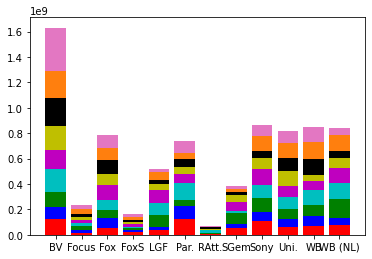

In [151]:
# create stacked box plot of mean film domestic gross by studio
y_2010 = domestic_gross_by_year.iloc[:,0]
y_2011 = domestic_gross_by_year.iloc[:,1]
y_2012 = domestic_gross_by_year.iloc[:,2]
y_2013 = domestic_gross_by_year.iloc[:,3]
y_2014 = domestic_gross_by_year.iloc[:,4]
y_2015 = domestic_gross_by_year.iloc[:,5]
y_2016 = domestic_gross_by_year.iloc[:,6]
y_2017 = domestic_gross_by_year.iloc[:,7]
y_2018 = domestic_gross_by_year.iloc[:,8]
g_index = domestic_gross_by_year.index

fig1, ax1 = plt.subplots()

ax1.bar(g_index,y_2010,color='r')
plt.bar(g_index,y_2011,bottom=y_2010,color='b')
plt.bar(g_index,y_2012,bottom=y_2010+y_2011,color='g')
plt.bar(g_index,y_2013,bottom=y_2010+y_2011+y_2012,color='c')
plt.bar(g_index,y_2014,bottom=y_2010+y_2011+y_2012+y_2013,color='m')
plt.bar(g_index,y_2015,bottom=y_2010+y_2011+y_2012+y_2013+y_2014,color='y')
plt.bar(g_index,y_2016,bottom=y_2010+y_2011+y_2012+y_2013+y_2014+y_2015,color='k')
plt.bar(g_index,y_2017,bottom=y_2010+y_2011+y_2012+y_2013+y_2014+y_2015+y_2016,color='tab:orange')
plt.bar(g_index,y_2018,bottom=y_2010+y_2011+y_2012+y_2013+y_2014+y_2015+y_2016+y_2017,color='tab:pink');

In [177]:
domestic.head()

,release_date,movie,production_budget,domestic_gross,domestic_roi,studio,year
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,0.587101,BV,2011
1,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1.388403,BV,2015
2,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2.262718,BV,2018
3,"Nov 17, 2017",Justice League,300000000,229024295,0.763414,WB,2017
4,"Nov 6, 2015",Spectre,300000000,200074175,0.666914,Sony,2015


In [187]:
# create a new table by pivoting data
# want to be able to calculate cumulative ROIs for studios
domestic_pivot = pd.pivot(dom_gross_by_studio, values = ['production_budget','domestic_gross'], index = 'studio',
                         columns = 'year')

In [188]:
# look at new pivot table
domestic_pivot.head()

production_budget                                                     \
year                2010        2011 2012       2013       2014        2015   
studio                                                                        
3D             5000000.0         NaN  NaN        NaN        NaN         NaN   
A24                  NaN         NaN  NaN  3750000.0  6900000.0  12000000.0   
ALP                  NaN  26000000.0  NaN        NaN        NaN         NaN   
ATO           12500000.0         NaN  NaN        NaN        NaN         NaN   
Affirm               NaN         NaN  NaN        NaN        NaN         NaN   

                                        domestic_gross                \
year         2016       2017       2018           2010     2011 2012   
studio                                                                 
3D            NaN        NaN        NaN      6096582.0      NaN  NaN   
A24     3750000.0  6420000.0  9000000.0            NaN      NaN  NaN   
ALP           NaN        NaN        NaN            NaN  42472.0  NaN   
ATO           NaN        NaN        NaN      2039869.0      NaN  NaN   
Affirm        NaN  2000000.0  5000000.0            NaN      NaN  NaN   

                                                                     \
year          2013       2014          2015        2016        2017   
studio                                                                
3D             NaN        NaN           NaN         NaN         NaN   
A24     10488628.5  2634715.6  1.590024e+07  8308194.25  15875475.0   
ALP            NaN        NaN           NaN         NaN         NaN   
ATO            NaN        NaN           NaN         NaN         NaN   
Affirm         NaN        NaN           NaN         NaN   5802208.0   

                    
year          2018  
studio              
3D             NaN  
A24     22616256.0  
ALP            NaN  
ATO            NaN  
Affirm  17547999.0

In [189]:
# the table has the necessary structure, but missing values are unhelpful
# need to remove those to see which studios have complete data
domestic_pivot = domestic_pivot.dropna(axis='rows')
domestic_pivot.head()

production_budget                                           \
year                2010         2011          2012          2013   
studio                                                              
BV          1.107143e+08  108460000.0  1.121429e+08  1.322500e+08   
Focus       9.750000e+06   18640000.0  3.375000e+07  1.325000e+07   
Fox         5.826923e+07   54000000.0  5.742308e+07  7.485714e+07   
FoxS        1.249625e+07   10187500.0  3.233750e+06  1.118125e+07   
LGF         2.816251e+07   29775000.0  4.256250e+07  3.975000e+07   

                                                                              \
year            2014          2015          2016          2017          2018   
studio                                                                         
BV      9.372000e+07  1.500143e+08  1.390909e+08  1.900000e+08  1.838625e+08   
Focus   1.880000e+07  1.500000e+07  3.090000e+07  2.700000e+07  2.000000e+07   
Fox     1.094167e+08  7.056667e+07  7.525000e+07  8.250000e+07  5.025000e+07   
FoxS    1.290000e+07  1.050000e+07  9.000000e+06  1.158333e+07  1.250000e+07   
LGF     7.375000e+07  3.938889e+07  1.833333e+07  2.450000e+07  2.483333e+07   

       domestic_gross                                                          \
year             2010          2011          2012          2013          2014   
studio                                                                          
BV       1.209646e+08  1.014376e+08  1.116478e+08  1.863871e+08  1.437242e+08   
Focus    1.614175e+07  2.211227e+07  3.035266e+07  2.317849e+07  2.376839e+07   
Fox      5.662486e+07  7.210326e+07  7.008285e+07  7.301630e+07  1.225286e+08   
FoxS     2.347915e+07  1.144864e+07  1.639746e+07  1.363887e+07  1.766510e+07   
LGF      3.650041e+07  2.527875e+07  9.243609e+07  9.398617e+07  1.032311e+08   

                                                                
year            2015          2016          2017          2018  
studio                                                          
BV      1.898553e+08  2.209764e+08  2.125611e+08  3.431461e+08  
Focus   2.423541e+07  2.367512e+07  4.342070e+07  3.012218e+07  
Fox     8.683504e+07  1.068002e+08  9.775460e+07  9.643077e+07  
FoxS    2.021568e+07  1.396039e+07  2.670466e+07  2.158532e+07  
LGF     5.067146e+07  2.975520e+07  6.239945e+07  2.334622e+07

In [190]:
# look at size of new table to see how many studios we will look at
domestic_pivot.shape[0]

12

Now that complete production budget and gross data has been isolated for 12 studios for the years 2010 to 2018, we can calculate cumulative data and use that to draw a conclusion about each studio's success, as determined by ROI.

In [199]:
# create dataframes with cumulative production budget and domestic gross data by year
budget_cum = np.cumsum(domestic_pivot.iloc[:,0:9], axis=1)
gross_cum = np.cumsum(domestic_pivot.iloc[:,9:19], axis=1)

# create dataframe with cumulative ROI data
roi_cum = pd.DataFrame()
for a in np.arange(2010,2019):
    roi_cum[a] = (gross_cum[('domestic_gross', a)] / 
                  budget_cum[('production_budget', a)])

roi_cum.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018
studio,,,,,,,,,
BV,1.092583,1.014728,1.008249,1.122679,1.191776,1.207429,1.270088,1.242342,1.336360
Focus,1.655564,1.347447,1.104066,1.217472,1.226814,1.280236,1.166851,1.238164,1.266807
Fox,0.971780,1.146602,1.171597,1.111543,1.114106,1.133460,1.176493,1.177685,1.236579
FoxS,1.878895,1.539771,1.980332,1.751113,1.652626,1.699951,1.680682,1.769934,1.764176
LGF,1.296064,1.066307,1.534480,1.769707,1.642208,1.586905,1.589341,1.668540,1.612197


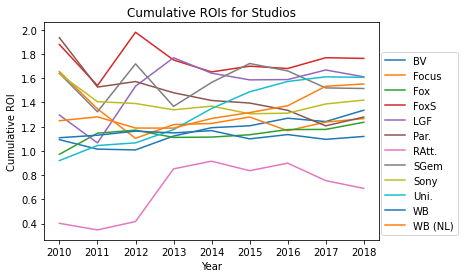

In [212]:
# plot cumulative ROI of studios from 2010 (first year of data) to 2018 (last year of data)
fig,ax = plt.subplots()
for b in range(roi_cum.shape[0]):
    ax.plot(roi_cum.columns, roi_cum.iloc[b,], label = roi_cum.index[b])
    
ax.legend(loc = 'lower right', bbox_to_anchor = (1.25,0))
ax.set_xlabel('Year', size = 10)
ax.set_ylabel('Cumulative ROI', size=10)
ax.set_title('Cumulative ROIs for Studios');

From looking at the plot of cumulative ROI over the years in question, we want to look at studios that not only have a high ROI at the beginning of the range, but also throughout the range. This is because strong initial returns are important to decide if investment in the studio should be ongoing (rather than discontinued), and strong returns over time suggest the studio will be viable as a going concern. 

From this plot, it appears that one studio fits this criteria well: FoxS. To highlight FoxS among the other studios, we can update this plot to better highlight the FoxS line.

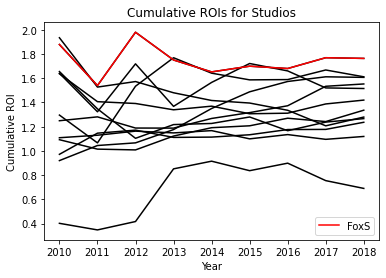

In [213]:
# plot cumulative ROI of studios from 2010 (first year of data) to 2018 (last year of data)
fig,ax = plt.subplots()
for b in range(roi_cum.shape[0]):
    ax.plot(roi_cum.columns, roi_cum.iloc[b,], color = 'black')
    
ax.plot(roi_cum.columns, roi_cum.loc['FoxS',:], color = 'red', label = 'FoxS')
ax.legend(loc = 'lower right')
ax.set_xlabel('Year', size = 10)
ax.set_ylabel('Cumulative ROI', size=10)
ax.set_title('Cumulative ROIs for Studios');

In [191]:
# create copy of studio_year_roi with cumulative columns
studio_year_gross_cum = np.cumsum(studio_year_roi.iloc[:,0:9], axis=1)
studio_year_budg_cum = np.cumsum(studio_year_roi.iloc[:,9:19], axis=1)

#studio_year_roi_cum = studio_year_gross_cum.reset_index(drop=True) / studio_year_budg_cum.reset_index(drop=True)
studio_year_roi_cum = pd.DataFrame()

#studio_year_roi_cum = studio_year_gross_cum.reset_index(drop=True) / studio_year_budg_cum.reset_index(drop=True)
for a in np.arange(2010,2019):
    studio_year_roi_cum[a] = (studio_year_gross_cum[('domestic_gross_y', a)] / 
                                           studio_year_budg_cum[('production_budget', a)])
    
studio_year_roi_cum.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018
studio,,,,,,,,,
BV,1.092583,1.000822,0.999268,1.116448,1.200699,1.212673,1.292363,1.275827,1.367730
Focus,1.655564,1.324723,1.109802,1.215656,1.226690,1.275910,1.116238,1.167887,1.192292
Fox,0.971780,1.146602,1.171597,1.108411,1.111696,1.134057,1.173507,1.174786,1.213363
FoxS,1.878895,1.497781,1.712959,1.567960,1.539164,1.579930,1.579293,1.685243,1.687317
LGF,1.296064,1.171914,1.614411,1.791891,1.703101,1.613981,1.614799,1.662366,1.610363


In [169]:
movie_budgets.head()
movie_gross_add_budget = pd.merge(movie_gross,movie_budgets,how='left',left_on='title',right_on='movie')

In [170]:
movie_gross_add_budget.head()

,title,studio,domestic_gross_x,foreign_gross,year,id,release_date,movie,production_budget,domestic_gross_y,worldwide_gross
0,Toy Story 3,BV,415000000.0,652000000,2010,47.0,"Jun 18, 2010",Toy Story 3,"$200,000,000","$415,004,880","$1,068,879,522"
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010,NaN,NaN,NaN,NaN,NaN,NaN
3,Inception,WB,292600000.0,535700000,2010,38.0,"Jul 16, 2010",Inception,"$160,000,000","$292,576,195","$835,524,642"
4,Shrek Forever After,P/DW,238700000.0,513900000,2010,27.0,"May 21, 2010",Shrek Forever After,"$165,000,000","$238,736,787","$756,244,673"


In [16]:
# need to remove movies where there is no production budget - cannot come to any conclusions without this
movie_gross_add_budget = movie_gross_add_budget.dropna(subset=['production_budget'])

In [17]:
# can look at ROI of studio by year
movie_gross_studio_year = movie_gross_add_budget.groupby(['studio','year']).sum()
movie_gross_studio_year['domestic_roi_total'] = (movie_gross_studio_year['domestic_gross_y'] / 
                                                 movie_gross_studio_year['production_budget'])

In [172]:
movie_gross_studio_year

domestic_gross_x     id  production_budget  domestic_gross_y  \
studio year                                                                 
3D     2010         6100000.0   31.0          5000000.0         6096582.0   
A24    2013        21000000.0   25.0          7500000.0        20977257.0   
       2014        13100000.0  221.0         34500000.0        13173578.0   
       2015        47700000.0  197.0         36000000.0        47700710.0   
       2016        33163000.0  165.0         15000000.0        33232777.0   
...                       ...    ...                ...               ...   
Wein.  2016        57900000.0  146.0         57000000.0        57966080.0   
       2017        15300000.0   98.0         40000000.0        15241688.0   
Yash   2012         3000000.0   64.0          9200000.0         3047539.0   
       2013         8000000.0   60.0         24000000.0         8031955.0   
       2016         6200000.0  100.0         11000000.0         5599781.0   

             worldwide_gross  domestic_roi  worldwide_roi  domestic_roi_total  
studio year                                                                    
3D     2010       16515203.0      1.219316       3.303041            1.219316  
A24    2013       38066202.0      5.566046       8.996631            2.796968  
       2014       19327141.0      4.833217       5.813941            0.381843  
       2015       92125003.0      3.844256       7.490473            1.325020  
       2016       52710884.0      9.419545      15.011853            2.215518  
...                      ...           ...            ...                 ...  
Wein.  2016      158374040.0      4.607816      12.866679            1.016949  
       2017       31195960.0      0.950629       1.898590            0.381042  
Yash   2012        5806666.0      0.331254       0.631159            0.331254  
       2013       11723620.0      0.334665       0.488484            0.334665  
       2016       72989781.0      0.509071       6.635435            0.509071  

[300 rows x 8 columns]

In [18]:
# create new table by pivoting data
# this will make it easier to calculate ROI (via colums) and produce charts
movie_gross_studio_year.head()
studio_year_roi = pd.pivot_table(movie_gross_studio_year, values = ['production_budget','domestic_gross_y'], 
                                 index='studio',columns='year')
studio_year_roi = studio_year_roi.dropna(axis='rows')
studio_year_roi.head()

domestic_gross_y                                           \
year               2010          2011         2012          2013   
studio                                                             
BV          846752076.0  1.014376e+09  781534541.0  1.491097e+09   
Focus        64567014.0  1.105614e+08  121410622.0  9.271397e+07   
Fox         736123170.0  9.373424e+08  911077035.0  1.022228e+09   
FoxS        187833172.0  1.144864e+08   65589851.0  1.091109e+08   
LGF         401504551.0  1.011150e+08  739488699.0  5.639170e+08   

                                                                             \
year            2014          2015          2016         2017          2018   
studio                                                                        
BV      1.437242e+09  1.328987e+09  2.430741e+09  850244295.0  2.745169e+09   
Focus   1.188419e+08  9.694162e+07  1.657258e+08  130262115.0  9.036653e+07   
Fox     1.470344e+09  1.302526e+09  1.281602e+09  977545978.0  7.714462e+08   
FoxS    7.066039e+07  8.086272e+07  1.396039e+07  160227957.0  4.317065e+07   
LGF     4.129245e+08  4.560431e+08  2.677968e+08  249597782.0  1.400773e+08   

       production_budget                                           \
year                2010          2011         2012          2013   
studio                                                              
BV           775000000.0  1.084600e+09  785000000.0  1.058000e+09   
Focus         39000000.0  9.320000e+07  135000000.0  5.300000e+07   
Fox          757500000.0  7.020000e+08  746500000.0  1.048000e+09   
FoxS          99970000.0  1.018750e+08   12935000.0  8.945000e+07   
LGF          309787650.0  1.191000e+08  340500000.0  2.385000e+08   

                                                                             
year            2014          2015          2016         2017          2018  
studio                                                                       
BV      9.372000e+08  1.050100e+09  1.530000e+09  760000000.0  1.470900e+09  
Focus   9.400000e+07  6.000000e+07  2.163000e+08   81000000.0  6.000000e+07  
Fox     1.313000e+09  1.058500e+09  9.030000e+08  825000000.0  4.020000e+08  
FoxS    5.160000e+07  4.200000e+07  9.000000e+06   69500000.0  2.500000e+07  
LGF     2.950000e+08  3.545000e+08  1.650000e+08   98000000.0  1.490000e+08

In [19]:
# create copy of studio_year_roi with cumulative columns
studio_year_gross_cum = np.cumsum(studio_year_roi.iloc[:,0:9], axis=1)
studio_year_budg_cum = np.cumsum(studio_year_roi.iloc[:,9:19], axis=1)

#studio_year_roi_cum = studio_year_gross_cum.reset_index(drop=True) / studio_year_budg_cum.reset_index(drop=True)
studio_year_roi_cum = pd.DataFrame()

#studio_year_roi_cum = studio_year_gross_cum.reset_index(drop=True) / studio_year_budg_cum.reset_index(drop=True)
for a in np.arange(2010,2019):
    studio_year_roi_cum[a] = (studio_year_gross_cum[('domestic_gross_y', a)] / 
                                           studio_year_budg_cum[('production_budget', a)])
    
studio_year_roi_cum.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018
studio,,,,,,,,,
BV,1.092583,1.000822,0.999268,1.116448,1.200699,1.212673,1.292363,1.275827,1.367730
Focus,1.655564,1.324723,1.109802,1.215656,1.226690,1.275910,1.116238,1.167887,1.192292
Fox,0.971780,1.146602,1.171597,1.108411,1.111696,1.134057,1.173507,1.174786,1.213363
FoxS,1.878895,1.497781,1.712959,1.567960,1.539164,1.579930,1.579293,1.685243,1.687317
LGF,1.296064,1.171914,1.614411,1.791891,1.703101,1.613981,1.614799,1.662366,1.610363


In [20]:
# only one studio has relatively high initial and cumulative ROI - FoxS
FoxS_row = studio_year_roi_cum.loc['FoxS',:]
FoxS_row

2010    1.878895
2011    1.497781
2012    1.712959
2013    1.567960
2014    1.539164
2015    1.579930
2016    1.579293
2017    1.685243
2018    1.687317
Name: FoxS, dtype: float64

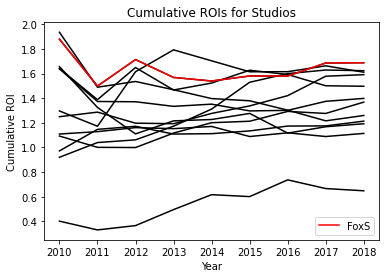

### Conclusion on finding a successful studio

From looking solely at the cumulative ROI of the studios for which we had continuous production data (which is not exhaustive), we can see that the studio "FoxS" had one of the highest initial ROIs and by 2018, the highest cumulative ROI. This is an appealing comparison for the trajectory of establishing a new studio because it suggests that it is possible to start with a relatively high ROI and maintain it over time, which should be the goal of Microsoft's new film unit.

### Confirming the drivers of successful films

Looking solely at this studios movies (that is, the subset that was used in drawing the above conclusion), the new goal is to see if the cumulative ROI of the studio is driven by a small number of films with high returns or achieving consistently high returns on a greater number of films.

In [119]:
# connect to database and confirm schema for local reference
conn = sqlite3.connect('im.db')
df = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)
df

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [120]:
movie_basics = pd.read_sql("""
SELECT *
    FROM movie_basics;
""",conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


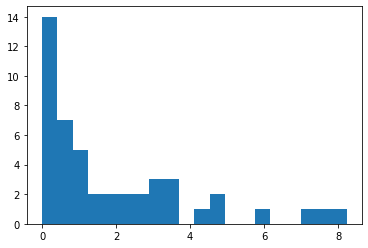

In [22]:
# create a dataframe with films from the FoxS studio
FoxS_movies = movie_gross_add_budget[movie_gross_add_budget['studio'] == 'FoxS']
FoxS_movies

# look at the histogram of ROIs for specific films 
fig, ax = plt.subplots()
ax.hist(FoxS_movies['domestic_roi'],bins=20);

In [23]:
# since the cumulative ROI of FoxS films hovered around 1.75 for the period observed,
# look at films with ROIs greater than that level
FoxS_movies_high_roi = FoxS_movies[FoxS_movies['domestic_roi'] > 1.75]
FoxS_movies_high_roi

,title,studio,domestic_gross_x,foreign_gross,year,id,release_date,movie,production_budget,domestic_gross_y,worldwide_gross,domestic_roi,worldwide_roi
17,Black Swan,FoxS,107000000.0,222400000,2010,46.0,"Dec 3, 2010",Black Swan,13000000.0,106954678.0,331266710.0,8.227283,25.482055
141,Just Wright,FoxS,21500000.0,29900,2010,85.0,"May 14, 2010",Just Wright,12000000.0,21540363.0,21867665.0,1.795030,1.822305
369,The Descendants,FoxS,82600000.0,94700000,2011,5.0,"Nov 16, 2011",The Descendants,20000000.0,82624961.0,175507800.0,4.131248,8.775390
557,Martha Marcy May Marlene,FoxS,3000000.0,548000,2011,42.0,"Oct 21, 2011",Martha Marcy May Marlene,1000000.0,2981038.0,5438911.0,2.981038,5.438911
583,Another Earth,FoxS,1300000.0,456000,2011,48.0,"Jul 22, 2011",Another Earth,175000.0,1321194.0,2102779.0,7.549680,12.015880
782,The Best Exotic Marigold Hotel,FoxS,46400000.0,90400000,2012,55.0,"May 4, 2012",The Best Exotic Marigold Hotel,10000000.0,46383639.0,134639780.0,4.638364,13.463978
870,Beasts of the Southern Wild,FoxS,12800000.0,8300000,2012,18.0,"Jun 27, 2012",Beasts of the Southern Wild,1800000.0,12795746.0,23265132.0,7.108748,12.925073
904,The Sessions,FoxS,6000000.0,3100000,2012,33.0,"Oct 19, 2012",The Sessions,1000000.0,6002451.0,11495204.0,6.002451,11.495204
1022,Sound of My Voice,FoxS,408000.0,NaN,2012,68.0,"Apr 27, 2012",Sound of My Voice,135000.0,408015.0,429448.0,3.022333,3.181096
1173,12 Years a Slave,FoxS,56700000.0,131100000,2013,18.0,"Oct 18, 2013",12 Years a Slave,20000000.0,56671993.0,181025343.0,2.833600,9.051267


In [24]:
# look at ratings of those FoxS movies versus the entire movie universe
# to do this, get data from IMBD database about this subset of films
new_sub = pd.merge(FoxS_movies_high_roi, movies, how = "inner", left_on = "title", right_on = "original_title")
new_sub = new_sub.drop_duplicates(subset=['title_x'])
new_sub.sort_values(['title_x'])

,title_x,studio,domestic_gross_x,foreign_gross,year,id_x,release_date_x,movie,production_budget,domestic_gross_y,...,Unnamed: 0,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title_y,vote_average,vote_count
9,12 Years a Slave,FoxS,56700000.0,131100000,2013,18.0,"Oct 18, 2013",12 Years a Slave,20000000.0,56671993.0,...,7911,"[18, 36]",76203,en,12 Years a Slave,16.493,2013-10-30,12 Years a Slave,7.9,6631
4,Another Earth,FoxS,1300000.0,456000,2011,48.0,"Jul 22, 2011",Another Earth,175000.0,1321194.0,...,2633,"[18, 878]",55420,en,Another Earth,10.030,2011-07-22,Another Earth,6.7,853
11,Baggage Claim,FoxS,21600000.0,887000,2013,38.0,"Sep 27, 2013",Baggage Claim,8500000.0,21569509.0,...,8084,[35],175528,en,Baggage Claim,8.666,2013-09-27,Baggage Claim,5.4,127
6,Beasts of the Southern Wild,FoxS,12800000.0,8300000,2012,18.0,"Jun 27, 2012",Beasts of the Southern Wild,1800000.0,12795746.0,...,5429,"[18, 14, 12]",84175,en,Beasts of the Southern Wild,7.530,2012-06-29,Beasts of the Southern Wild,6.9,605
0,Black Swan,FoxS,107000000.0,222400000,2010,46.0,"Dec 3, 2010",Black Swan,13000000.0,106954678.0,...,47,"[18, 53]",44214,en,Black Swan,13.745,2010-12-03,Black Swan,7.6,8374
14,Brooklyn,FoxS,38300000.0,23800000,2015,79.0,"Nov 4, 2015",Brooklyn,11000000.0,38322743.0,...,14276,"[18, 10749]",167073,en,Brooklyn,12.083,2015-11-04,Brooklyn,7.3,1912
10,Enough Said,FoxS,17600000.0,7700000,2013,88.0,"Sep 18, 2013",Enough Said,8000000.0,17550872.0,...,8081,"[35, 18, 10749]",209263,en,Enough Said,8.722,2013-09-18,Enough Said,6.7,464
20,Gifted,FoxS,24800000.0,18200000,2017,4.0,"Apr 7, 2017",Gifted,7000000.0,24801212.0,...,20682,"[18, 10751, 35]",400928,en,Gifted,16.745,2017-04-12,Gifted,7.9,2035
1,Just Wright,FoxS,21500000.0,29900,2010,85.0,"May 14, 2010",Just Wright,12000000.0,21540363.0,...,312,"[35, 18, 10749]",38093,en,Just Wright,7.047,2010-05-14,Just Wright,6.2,211
3,Martha Marcy May Marlene,FoxS,3000000.0,548000,2011,42.0,"Oct 21, 2011",Martha Marcy May Marlene,1000000.0,2981038.0,...,2656,"[18, 53]",50837,en,Martha Marcy May Marlene,9.477,2011-10-21,Martha Marcy May Marlene,6.7,413


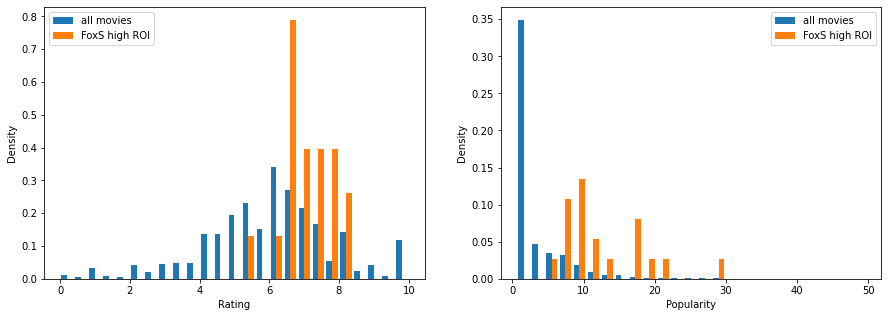

In [25]:
# look at rating for these movies versus those of the entire movie universe
fig, ax = plt.subplots(figsize = (15,5),ncols = 2)

# histogram of movie ratings
x = movies['vote_average']
y = new_sub['vote_average']
ax[0].hist([x,y],bins = 25, label = ["all movies", "FoxS high ROI"], density=True);
ax[0].legend(loc = "upper left")
ax[0].set_xlabel('Rating', size = 10)
ax[0].set_ylabel('Density', size = 10)

# histogram of movie popularity
x1 = movies[movies['popularity'] < 50]['popularity']
y1 = new_sub[new_sub['popularity'] < 50]['popularity']
ax[1].hist([x1,y1],bins = 25, label = ["all movies", "FoxS high ROI"], density=True);
ax[1].legend(loc = "upper right")
ax[1].set_xlabel('Popularity', size = 10)
ax[1].set_ylabel('Density', size = 10);

### Conclusions from subset of studio films

From looking at the histograms of movie ratings and popularity of the observed FoxS films versus the rest of the movie universe, we see that the relevant films have 1) a concentration of high ratings, and 2) higher, though still widely dispersed, popularity ratings. While neither of these results is unexpected, it suggests that we should focus on determining the underlying divers of the higher ratings to focus on making films with those attributes.

### Look at genres of highly rated / popular films

In [26]:
movies_new = pd.merge(movies, movie_basics, left_on = 'title', right_on = 'original_title')

In [27]:
movies_new = movies_new[['title','vote_average','movie_id','start_year','runtime_minutes','genres','popularity']]

# split genre strings to make easier to analyze
movies_new['genres'] = movies_new['genres'].apply(lambda x: x.split(',') if x else x)

In [28]:
movies_new.head()

,title,vote_average,movie_id,start_year,runtime_minutes,genres,popularity
0,Harry Potter and the Deathly Hallows: Part 1,7.7,tt0926084,2010,146.0,"[Adventure, Fantasy, Mystery]",33.533
1,How to Train Your Dragon,7.7,tt0892769,2010,98.0,"[Action, Adventure, Animation]",28.734
2,Iron Man 2,6.8,tt1228705,2010,124.0,"[Action, Adventure, Sci-Fi]",28.515
3,Inception,8.3,tt1375666,2010,148.0,"[Action, Adventure, Sci-Fi]",27.920
4,Percy Jackson & the Olympians: The Lightning T...,6.1,tt0814255,2010,118.0,"[Adventure, Family, Fantasy]",26.691


In [29]:
# get a list of unique genres
all_genres = set()

for item in movies_new['genres']:
    if item:
        all_genres.update(item)

In [30]:
all_genres

{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [31]:
# create a new dataframe with mean values for each genre
movies_new = pd.merge(movies, movie_basics, left_on = 'title', right_on = 'original_title')
movies_new = movies_new[['title','vote_average','movie_id','start_year','runtime_minutes','genres','popularity']]

#genre_stats = dict()

#for g in all_genres:
 #   genre_stats['genre'] = g
  #  genre_stats['vote_average'] = movies_new.groupby(movies_new['genres'].contains(g)).mean()
   # genre_stats['vote_average'] = movies_new.groupby(movies_new['genres'].contains(g)).mean()
  #  genre_stats['vote_average'] = movies_new.groupby(movies_new['genres'].contains(g)).mean()

In [32]:
movies_new.groupby(movies_new['genres'].str.contains('Drama')).mean()

,vote_average,start_year,runtime_minutes,popularity
genres,,,,
False,5.668531,2014.387544,87.557182,3.608547
True,5.925124,2014.363235,96.257258,4.074216


In [68]:
FoxS_movies['release_date'] = pd.to_datetime(FoxS_movies['release_date'],format='%Y-%mm-%d')
FoxS_movies['release_month'] = FoxS_movies['release_date'].dt.month
FoxS_movies['date_in_year'] = FoxS_movies['release_date'].dt.dayofyear

FoxS_movies.head()

<ipython-input-68-d9ac46a9a49e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FoxS_movies['release_date'] = pd.to_datetime(FoxS_movies['release_date'],format='%Y-%mm-%d')
<ipython-input-68-d9ac46a9a49e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FoxS_movies['release_month'] = FoxS_movies['release_date'].dt.month
<ipython-input-68-d9ac46a9a49e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,title,studio,domestic_gross_x,foreign_gross,year,id,release_date,movie,production_budget,domestic_gross_y,worldwide_gross,domestic_roi,worldwide_roi,release_month,date_in_year
17,Black Swan,FoxS,107000000.0,222400000,2010,46.0,2010-12-03,Black Swan,13000000.0,106954678.0,331266710.0,8.227283,25.482055,12,337
95,127 Hours,FoxS,18300000.0,42400000,2010,6.0,2010-11-05,127 Hours,18000000.0,18335230.0,60217171.0,1.018624,3.345398,11,309
119,My Name is Khan,FoxS,4000000.0,38300000,2010,52.0,2010-02-12,My Name is Khan,8470000.0,4046336.0,42355526.0,0.477726,5.000652,2,43
141,Just Wright,FoxS,21500000.0,29900,2010,85.0,2010-05-14,Just Wright,12000000.0,21540363.0,21867665.0,1.795030,1.822305,5,134
142,Our Family Wedding,FoxS,20300000.0,1200000,2010,95.0,2010-03-12,Our Family Wedding,14000000.0,20255281.0,21410546.0,1.446806,1.529325,3,71


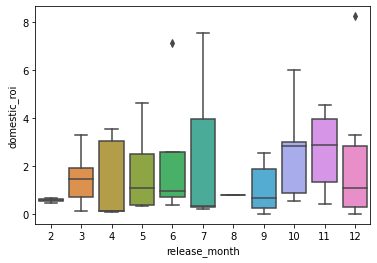

In [75]:
fig,ax = plt.subplots()

sns.boxplot(x = FoxS_movies['release_month'], y = FoxS_movies['domestic_roi']);

#sns.scatterplot(x = FoxS_movies['date_in_year'], y = FoxS_movies['domestic_roi']);

<ipython-input-74-f574f28c5838>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_budgets_posGross['release_date'] = pd.to_datetime(movie_budgets_posGross['release_date'])
<ipython-input-74-f574f28c5838>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_budgets_posGross['release_month'] = movie_budgets_posGross['release_date'].dt.month
<ipython-input-74-f574f28c5838>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

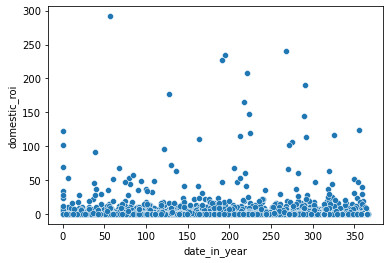

In [74]:
movie_budgets_posGross['release_date'] = pd.to_datetime(movie_budgets_posGross['release_date'])
movie_budgets_posGross['release_month'] = movie_budgets_posGross['release_date'].dt.month
movie_budgets_posGross['date_in_year'] = movie_budgets_posGross['release_date'].dt.dayofyear
movie_budgets_posGross.head()

fig,ax = plt.subplots()

#sns.boxplot(x = movie_budgets_posGross['release_month'], y = movie_budgets_posGross['domestic_roi']);
sns.scatterplot(x = movie_budgets_posGross['date_in_year'], y = movie_budgets_posGross['domestic_roi']);

### Looking at drivers of rating and popularity for the subset of studio films


From looking only at the selected films, a lot of their genre identifiers appear to be '18'. So genre seems to be a good place to start looking at some film attributes.

Additionally, it makes sense to look at the individuals involved in these films and see if there is any overlap that the new studio can use to target specific individuals.

In [26]:
# drill down on specific films
FoxS_titles = list(FoxS_movies_high_roi['title'])

FoxS_basics = movie_basics[movie_basics['original_title'].isin(FoxS_titles)]
FoxS_basics.sort_values(['primary_title'])

# there are some duplicates in the table due to different films of the same name - need to remove these
dupes = ['tt3184798','tt3727750','tt5838908','tt1458730']
FoxS_basics = FoxS_basics[~FoxS_basics['movie_id'].isin(dupes)]

In [27]:
FoxS_basics.sort_values('primary_title')
FoxS_basics_ids = list(FoxS_basics['movie_id'])
FoxS_basics_ids

['tt0947798',
 'tt1033575',
 'tt1171222',
 'tt1407061',
 'tt1412386',
 'tt1441326',
 'tt1549572',
 'tt1748207',
 'tt1866249',
 'tt2024544',
 'tt2125435',
 'tt2278388',
 'tt2381111',
 'tt2390361',
 'tt2555736',
 'tt4481414',
 'tt5027774',
 'tt5083738',
 'tt5580390']

In [28]:
# get more info on persons in films
movie_knownFor = pd.read_sql("""
SELECT *
    FROM known_for;
""",conn)

movie_persons = pd.read_sql("""
SELECT *
    FROM persons;
""",conn)

movie_knownFor_FoxS = movie_knownFor[movie_knownFor['movie_id'].isin(FoxS_basics_ids)]

In [29]:
# create new table with films and individuals
movie_persons_FoxS = pd.merge(movie_knownFor_FoxS, movie_persons)
movie_persons_FoxS.head()

persons_frequency = movie_persons_FoxS.value_counts(['primary_name'])

# manually examine which names have 2+ mentions in persons table
persons_frequency = persons_frequency[0:23]

key_persons = []
for c in persons_frequency.keys():
    key_persons.append(c[0])

key_persons

key_persons_all = movie_persons[movie_persons['primary_name'].isin(key_persons)]

key_persons_all

,person_id,primary_name,birth_year,death_year,primary_profession
2366,nm0370035,John Hawkes,1959.0,NaN,"actor,soundtrack,music_department"
17065,nm0281765,Renée Fleming,1959.0,NaN,"actress,soundtrack,music_department"
26306,nm0239267,Lillete Dubey,1953.0,NaN,"actress,producer"
29818,nm0110357,Graham Broadbent,NaN,NaN,producer
34749,nm10084433,Seema Azmi,NaN,NaN,actress
62345,nm0583796,Paul Mezey,NaN,NaN,"producer,sound_department,production_manager"
67164,nm0005299,Sarah Paulson,1974.0,NaN,"actress,soundtrack,director"
74993,nm0362051,Diana Hardcastle,NaN,NaN,actress
81077,nm0780678,Nick Searcy,1959.0,NaN,"actor,director,writer"
106681,nm0003202,David G. Russell,1968.0,NaN,"music_department,composer"


In [78]:
# take subset of movie database for genre comparise to FoxS subset
# select movies between 2010 and 2018
movies_compare = movie_basics[movie_basics['start_year'] >= 2010]
movies_compare = movies_compare[movies_compare['start_year'] <= 2018]
movies_compare = movies_compare.dropna(subset = ['genres'])

In [83]:
# count number of films from each genre for bar charts
genres = ['Drama','Thriller','Comedy','Romance','Sport','Mystery','Sci-Fi',
          'Biography','History','Crime','Adventure']
genres_count_FoxS = []
genres_count_all = []

for g in genres:
    genres_count_FoxS.append(sum(FoxS_basics['genres'].str.contains(g))/FoxS_basics.shape[0])
    genres_count_all.append(sum(movies_compare['genres'].str.contains(g))/movies_compare.shape[0])

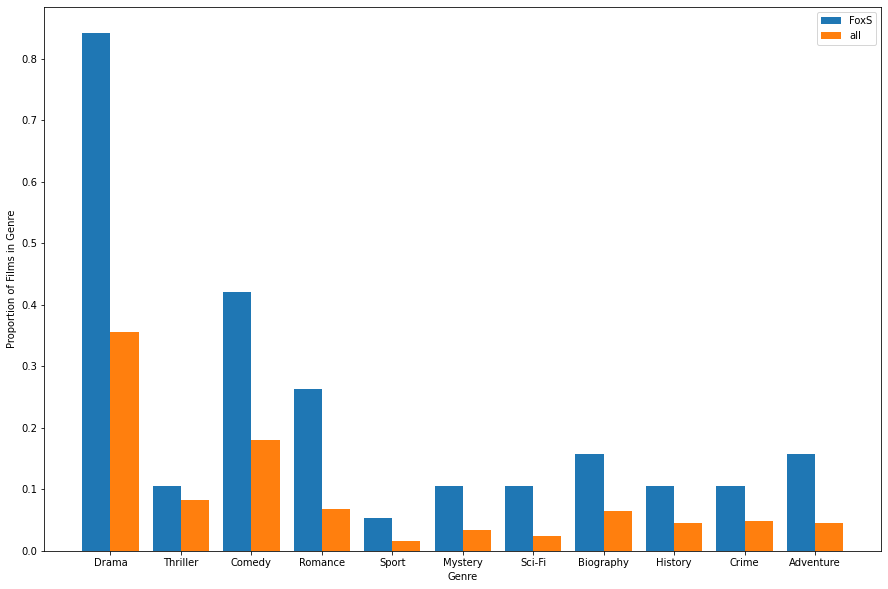

In [97]:
# construct bar chart
fig2, ax2 = plt.subplots(figsize = (15,10))
x_axis = np.arange(len(genres))

ax2.bar(x_axis-.2,genres_count_FoxS,0.4,label='FoxS')
ax2.bar(x_axis+.2,genres_count_all,0.4,label='all')
plt.xticks(x_axis,genres)
ax2.legend(loc = "upper right")
ax2.set_xlabel('Genre', size = 10)
ax2.set_ylabel('Proportion of Films in Genre', size = 10);

## Conclusions from attributes of the subset of studio films

Looking at the subset of studio films, it appears that there is very little overlap in key persons in the films that scored well in rating and popularity. Therefore, it is hard to determine that specific individuals should be targeted as drivers of those ratings. However, looking at corresponding genres, there is a very high proportion of dramas; in fact, 16 of 19 films are described as dramas in the dataset. Though the genres of the high-scoring films are well-distributed, the overall high proportion of dramas suggests that genre should be targeted to make highly-rated and popular films.